# 2019년 12월 26일

- DCGAN (Deep Convolution GAN) 

## Pix2Pix

짝을 이뤄서 학습시킨다. 

In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

UC Berkeley - pytorch를 사용한다. 

In [2]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

In [3]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

classification -> transfer learning 

r-cnn : 예측 속도가 느리다. 

keras: gpu 자동 할당 

In [4]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

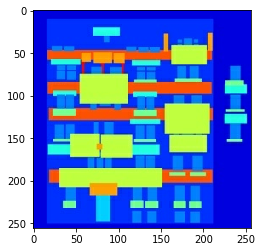

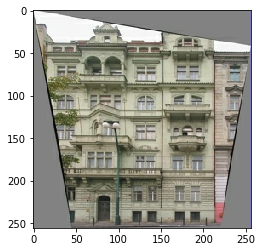

In [5]:
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255.0)
plt.figure()
plt.imshow(re/255.0)

ResizeMethod -> interpolation(options) 

In [6]:
# [height, width] -> duck typing 
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [7]:
dir(tf.image)
# PIL 에서 이용할 수 있는것 tf.image에서 사용할 수 있다. 
# PIL은 사용하기 편하지만 속도가 느리다. 
# tf.image는 opencv보다는 쉽지만 PIL보다는 사용하기 어렵다. 

['ResizeMethod',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'adjust_brightness',
 'adjust_contrast',
 'adjust_gamma',
 'adjust_hue',
 'adjust_jpeg_quality',
 'adjust_saturation',
 'central_crop',
 'combined_non_max_suppression',
 'convert_image_dtype',
 'crop_and_resize',
 'crop_to_bounding_box',
 'decode_and_crop_jpeg',
 'decode_bmp',
 'decode_gif',
 'decode_image',
 'decode_jpeg',
 'decode_png',
 'draw_bounding_boxes',
 'encode_jpeg',
 'encode_png',
 'extract_glimpse',
 'extract_jpeg_shape',
 'extract_patches',
 'flip_left_right',
 'flip_up_down',
 'grayscale_to_rgb',
 'hsv_to_rgb',
 'image_gradients',
 'is_jpeg',
 'non_max_suppression',
 'non_max_suppression_overlaps',
 'non_max_suppression_padded',
 'non_max_suppression_with_scores',
 'pad_to_bounding_box',
 'per_image_standardization',
 'psnr',
 'random_brightness',
 'random_contrast',
 'random_crop',
 'random_flip_left_right',
 'random_f

In [8]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [9]:
tf.image.random_flip_left_right
# random은 나중에 학습 데이터 사용하는데 쓴다. 

<function tensorflow.python.ops.image_ops_impl.random_flip_left_right(image, seed=None)>

In [10]:
# normalizing the images to [-1, 1] 요즘에는 -1~1로 쓴다. 
# 학습이 조금 더 잘된다. 
# 255/(255/2) - 1 -> leaky relu를 쓴다. 
# hyperbolic tangent 와 비슷하다. 
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [11]:
# tf.function -> tf여야지 쓴다. 

@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [12]:
import numpy as np

- stack 하면 차원이 증가되는 단점이 있따. 

In [13]:
a = np.array([1,2,3])
b = np.array([4,5,6])

In [14]:
np.stack([a,b])

array([[1, 2, 3],
       [4, 5, 6]])

In [15]:
np.hstack([a,b])

array([1, 2, 3, 4, 5, 6])

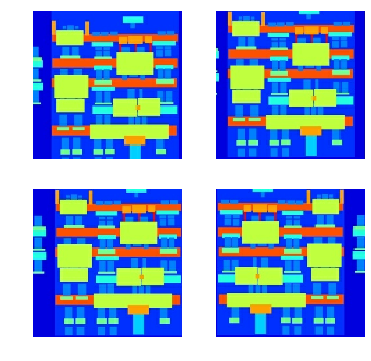

In [16]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

데이터가 작으므로 **tf.image**를 써서 augmentation을 해야한다. 

In [17]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [18]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [19]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [20]:
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

- Build the Generator

In [21]:
OUTPUT_CHANNELS = 3

In [22]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [23]:
# INPUT
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [24]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [25]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


keras는 layer한개로 인식할 수 있다. 

In [26]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
#     크기 똑같이 맞추기 위해 
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [27]:
inputs = tf.keras.layers.Input(shape=[256,256,3])

down_stack = [
downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
downsample(128, 4), # (bs, 64, 64, 128)
downsample(256, 4), # (bs, 32, 32, 256)
downsample(512, 4), # (bs, 16, 16, 512)
downsample(512, 4), # (bs, 8, 8, 512)
downsample(512, 4), # (bs, 4, 4, 512)
downsample(512, 4), # (bs, 2, 2, 512)
downsample(512, 4), # (bs, 1, 1, 512)
]

up_stack = [
upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
upsample(512, 4), # (bs, 16, 16, 1024)
upsample(256, 4), # (bs, 32, 32, 512)
upsample(128, 4), # (bs, 64, 64, 256)
upsample(64, 4), # (bs, 128, 128, 128)
]

initializer = tf.random_normal_initializer(0., 0.02)
#     크기 똑같이 맞추기 위해 
last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                     strides=2,
                                     padding='same',
                                     kernel_initializer=initializer,
                                     activation='tanh') # (bs, 256, 256, 3)

x = inputs

In [28]:
skips = []
for down in down_stack:
    x = down(x)
    skips.append(x)

skips = reversed(skips[:-1])

In [33]:
for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

x = last(x)

In [42]:
x

<tf.Tensor 'conv2d_transpose_8/Identity:0' shape=(None, 2, 2, 3) dtype=float32>

In [38]:
# window에서는 graphviz를 깔아야하는데, 복잠해서 안될 것이다. 
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


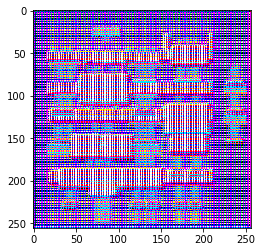

In [39]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])

In [40]:
LAMBDA = 100

In [41]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [43]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [44]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


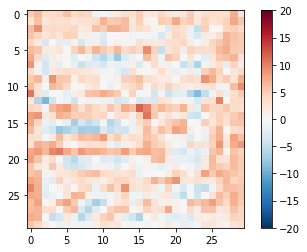

In [45]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [46]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [47]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [48]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

- checkpoint를 저장할 수 있다.

```python
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
```

- 학습

In [49]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

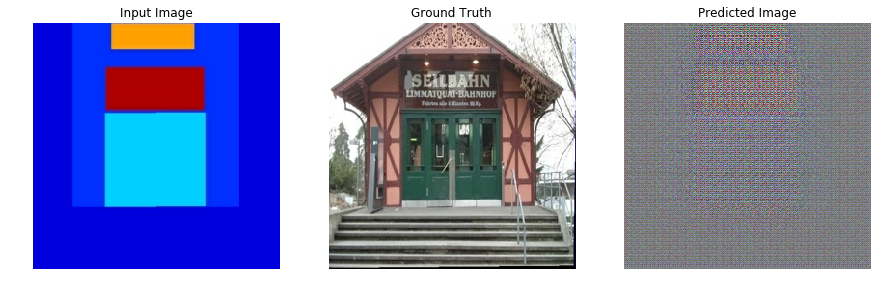

In [50]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [51]:
EPOCHS = 10

- tf.summary -> tensorboard 

In [53]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# create_file_writer => .as_default => tf.summary.scalar 

In [63]:
dir(summary_writer.as_default())
# 파일이 저장된다. 

# as_default: __enter__, __exit__

['__abstractmethods__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_recreate_cm',
 'args',
 'func',
 'gen',
 'kwds']

In [73]:
# gradient Tape

@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default(): # 파일 타입이고 __enter, __exit가 있기 때문에 with구문을 써서 사용한다. 
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)
#     tensorboard를 쓸 때 Summary를 만들어서 쓴다. 

In [70]:
dir(summary_writer.as_default().__exit__)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [55]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
#         gradient tape 
      train_step(input_image, target, epoch)
    print()

    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix = checkpoint_prefix)

In [56]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "d:\01_program\anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "d:\01_program\anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\01_Program\Anaconda3\Scripts\tensorboard.exe\__main__.py", line 7, in <module>
  File "d:\01_program\anaconda3\lib\site-packages\tensorboard\main.py", line 64, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "d:\01_program\anaconda3\lib\site-packages\absl\app.py", line 299, in run
    _run_main(main, args)
  File "d:\01_program\anaconda3\lib\site-packages\absl\app.py", line 250, in _run_main
    sys.exit(main(argv))
  File "d:\01_program\anaconda3\lib\site-packages\tensorboard\program.py", line 220, in main
    server = self._make_server()
  File "d:\01_program\anaconda3\lib\site-packages\tensorboard\program.py", line 299, in _make_s

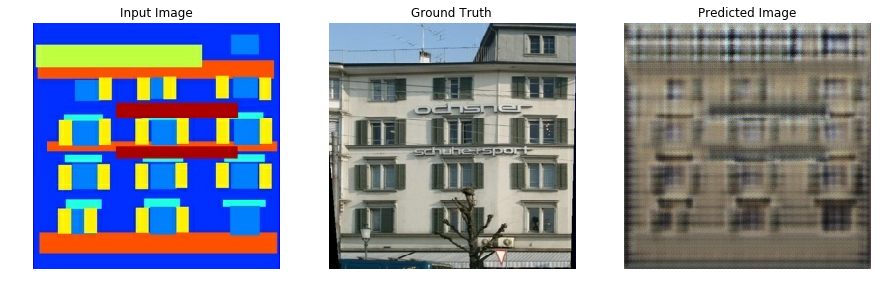

Epoch:  0
.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\01_Program\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-74-91e4b5f743cc>", line 1, in <module>
    fit(train_dataset, EPOCHS, test_dataset)
  File "<ipython-input-55-7bba0c4967a4>", line 16, in fit
    train_step(input_image, target, epoch)
  File "D:\01_Program\Anaconda3\lib\site-packages\tensorflow_core\python\eager\def_function.py", line 457, in __call__
    result = self._call(*args, **kwds)
  File "D:\01_Program\Anaconda3\lib\site-packages\tensorflow_core\python\eager\def_function.py", line 503, in _call
    self._initialize(args, kwds, add_initializers_to=initializer_map)
  File "D:\01_Program\Anaconda3\lib\site-packages\tensorflow_core\python\eager\def_function.py", line 408, in _initialize
    *args, **kwds))
  File "D:\01_Program\Anaconda3\lib\site-packages\tensorflow_core\python\eager\function.py", line 1848, in _g

KeyboardInterrupt: 

In [74]:
fit(train_dataset, EPOCHS, test_dataset)

In [58]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

### CycleGan

https://www.tensorflow.org/tutorials/generative/cyclegan

In [78]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [79]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [88]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

D:\01_Program\Anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cycle_gan downloaded and prepared to C:\Users\조경아\tensorflow_datasets\cycle_gan\horse2zebra\0.1.0. Subsequent calls will reuse this data.


In [81]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [82]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [83]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [84]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [85]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [86]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [89]:
# .cache(): 다운받은거 또 받지 않도록 도와주는 것 
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)